# Isometric Non-Rigid Structure-from-Motion

Non Rigid Structure from Motion problem deals with recovering the shape of an object from several monocular images is one of the hardest problems in computer vision. In this notebook, we are going to explore the work Isometric Non-Rigid Shape-from-Motion with Riemannian Geometry Solved in Linear Time from Shaifali Parashar, Daniel Pizarro and Adrien Bartoli. The method is able to recover the normals of the object and the relative depth through isometry working with perpective camera model. 

Isometry is the assumption of invariance in the geodesic distance of a surface. If we want to meassure the distance between two points in a surface, we will use the concept of Riemannian manifold. A manifold is a topological space that locally resembles Euclidean space near each point... in a word, a surface embedded in 3D. 

The surface is parametrized in the image observing it. The depth of a pixel is defined as:

\begin{equation*}
\phi_k\left(\hat{x},\hat{y}\right) = \begin{bmatrix}\frac{\hat{x}}{\beta(\hat{x},\hat{y})} & \frac{\hat{y}}{\beta(\hat{x},\hat{y})} & \frac{1}{\beta(\hat{x},\hat{y})}
\end{bmatrix}^\top,
\end{equation*} where $\beta_k(\hat{x},\hat{y})$ is the inverse depth of each point.

In [2]:
from sympy import *
init_printing(use_unicode=True)

x,y = symbols('\hat{x} \hat{y}')
b = Function('beta')(x,y)

phi = 1/b*Matrix([[x],[y],[1]])

bx = diff(f,x).T
by = diff(f,y).T

J = Matrix([bx,by]).T

J

NameError: name 'f' is not defined

We can now recover the tangent space of this parametrization through the jacobian.

\begin{equation*}
J = \frac{1}{\beta}\begin{bmatrix}
k_{\hat{x}}\hat{x}-1 & k_{\hat{y}}\hat{x}\\ 
k_{\hat{x}}\hat{y} & k_{\hat{y}}\hat{y}-1\\ 
k_{\hat{x}} & k_{\hat{y}}
\end{bmatrix}
\end{equation*}, being $k_{\hat{x}}=\frac{1}{\beta}\frac{\partial \beta}{\partial\hat{x}}$ and $k_{\hat{y}}=\frac{1}{\beta}\frac{\partial \beta}{\partial\hat{y}}$

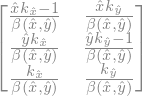

In [3]:
#For original image
kx, ky = symbols('k_{\hat{x}} k_{\hat{y}}',real=True)

Jk =  1/b *Matrix([[kx*x-1,ky*x],[kx*y,ky*y-1],[kx,ky]]) 

factor(Jk)

What should we conserve during the different images: Isometry. That means that the distances between points going through the surface should be preserve. We express this matematically through the differential distance $$ds^2 = g_{11}d_u^2+2g_{12}d_ud_v+g_{22}d_v^2$$

This can be express through the first fundamental form, the metric tensor $G$, as:

$$ds^2 = \begin{bmatrix}
du & dv 
\end{bmatrix} G \begin{bmatrix}
du \\ dv 
\end{bmatrix}$$

This metric tensor is estimated as $ G = J^\top J$

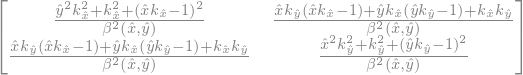

In [7]:
G = Jk.T*Jk
simplify(G)


In [73]:
#For original image
m1, n1, km1, kn1, b1 = symbols('m1 n1 km1 kn1 beta_1',real=True)
#For second image
m2, n2, km2, kn2, b2 = symbols('m2 n2 km2 kn2 beta_2',real=True)

# Metric tensor estimation without depth
def metric_tensor_symbolic(m,n,km,kn):
    """Metric tensor estimation without depth"""
    g11 = (km*m-1)**2+(km*n)**2+km**2 # Abreviated as E
    g12 = km*kn*(m**2+n**2+1)-kn*m-km*n # Abreviated as F
    g22 = (kn*m)**2+(kn*n-1)**2+kn**2 # Abreviated as G
    Ges =  Matrix([[g11,g12],[g12,g22]])
    return g11,g12,g22,Ges

In [71]:
g111,g121,g221,G1 = metric_tensor_symbolic(m1,n1,km1,kn1)
g112,g122,g222,G2 = metric_tensor_symbolic(m2,n2,km2,kn2)

Under isometric variations in the surface the metric tensor remains the same. We can relate what we have observed in the image original $k$ image with the rest of images $k^*$ though a warp $\eta$. This warp is a bijective transformation that explain how the image have changed. 

So relating the surface parametrized in the original image with the new image thorugh a warp $\eta_{12}$  

$$g_{k}(\hat{x},\hat{y}) = J_{\eta_{k k^*}}^\top g_{k^*}(\hat{x}^*,\hat{y}^*) J_{\eta_{k k^*}} $$

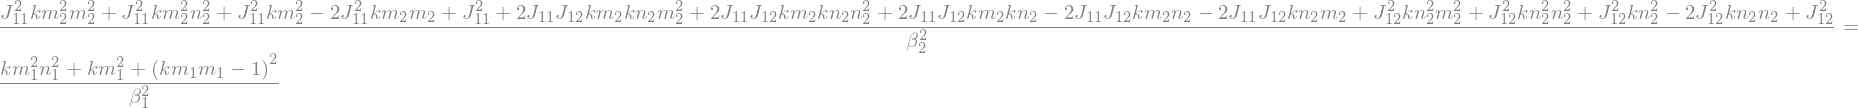

In [96]:
# Connect Warp Connections
j11, j12, j22, H111, H121, H221, H112, H122, H222  = symbols('J11 J12 J22 H111 H121 H221 H112 H122 H222',real=True)
J13_11, J13_12, J13_22, H13_110, H13_120, H13_220, H13_111, H13_121, H13_221  = symbols('J^12_11 J^12_12 J^12_22 H^12_110 H^12_120 H^12_220 H^12_111 H^12_121 H^12_221',real=True)
J12 = Matrix([[j11,j12],[j12,j22]])
H0 = Matrix([[H111,H121],[H121,H221]])
H1 = Matrix([[H112,H122],[H122,H222]])
J12inv = J12**(-1)

G2J = J12.T*G2*J12

Eq((simplify(expand(1/b2**2*J12.T*G2*J12)))[0,0],1/b1**2*G1[0,0])

6 incognites and 3 equations: We need more equations. To solve it, we use the second fundamental form, the Christophel symbols. They come directly from the metric tensor derivatives: 

In [99]:
# Cristophel symbols first kind
def derivate_metric_tensor(m,n,km,kn,g11,g12,g22):
    # Derivatives without taking into account depth
    Em_par = 2*(km*m-1)*(-km**2*m+km)-2*n*km**3*n-2*km**3
    Fm_par = -2*km**2*kn*(m**2+n**2+1)+km*kn*3*m-kn+km**2*n
    Gm_par =  2*kn*m*(-kn*km*m+kn)+2*(kn*n-1)*(-kn*km*n)-kn**2*km*2
    En_par =  2*(km*m-1)*(-kn*km*m)+2*km*n*(-km*kn*n+km)-2*kn*km**2
    Fn_par =  -2*km*kn**2*(m**2+n**2+1)+km*kn*3*n-km+kn**2*m
    Gn_par =  -2*kn**3*m**2+2*(kn*n-1)*(-kn**2*n+kn)-2*kn**3
    # Derivatives taking into account depth but without including it. The depth 
    # vanishes in the Christophel symbols
    Em_noB = Em_par - 2*g11*km
    Fm_noB = Fm_par - 2*g12*km
    Gm_noB = Gm_par - 2*g22*km
    En_noB = En_par - 2*g11*kn
    Fn_noB = Fn_par - 2*g12*kn
    Gn_noB = Gn_par - 2*g22*kn
    return Em_noB,Fm_noB,Gm_noB,En_noB,Fn_noB,Gn_noB

Em_noB1,Fm_noB1,Gm_noB1,En_noB1,Fn_noB1,Gn_noB1 = derivate_metric_tensor(m1,n1,km1,kn1,g111,g121,g221)
Em_noB2,Fm_noB2,Gm_noB2,En_noB2,Fn_noB2,Gn_noB2 = derivate_metric_tensor(m2,n2,km2,kn2,g112,g122,g222)

# Metric tensor inverse
ginv1 = 1/(g111*g221-g121**2)*Matrix([[g221,-g121],[-g121,g111]])
ginv2 = 1/(g112*g222-g122**2)*Matrix([[g222,-g122],[-g122,g112]])

# Cristophel symbols second kind
def christophel_symbols_second_kind(ginv,Em_noB,Fm_noB,Gm_noB,En_noB,Fn_noB,Gn_noB):
    Gamma001 =  ginv[0,0]*(1/2*Em_noB)+ginv[0,1]*(Fm_noB-1/2*En_noB)
    Gamma002 =  ginv[1,0]*(1/2*Em_noB)+ginv[1,1]*(Fm_noB-1/2*En_noB)
    Gamma011 =  ginv[0,0]*(1/2*En_noB)+ginv[0,1]*(1/2*Gm_noB)
    Gamma012 =  ginv[1,0]*(1/2*En_noB)+ginv[1,1]*(1/2*Gm_noB)
    Gamma101 =  Gamma011
    Gamma102 =  Gamma012
    Gamma111 =  ginv[0,0]*(Fn_noB-1/2*Gm_noB)+ginv[0,1]*(1/2*Gn_noB)
    Gamma112 =  ginv[1,0]*(Fn_noB-1/2*Gm_noB)+ginv[1,1]*(1/2*Gn_noB)
    Gamma1 = simplify(Matrix([[Gamma001,Gamma101],[Gamma011,Gamma111]]))
    Gamma2 = simplify(Matrix([[Gamma002,Gamma102],[Gamma012,Gamma112]]))
    return Gamma1,Gamma2

Gamma11, Gamma21 = christophel_symbols_second_kind(ginv1,Em_noB1,Fm_noB1,Gm_noB1,En_noB1,Fn_noB1,Gn_noB1)
Gamma12, Gamma22 = christophel_symbols_second_kind(ginv2,Em_noB2,Fm_noB2,Gm_noB2,En_noB2,Fn_noB2,Gn_noB2)

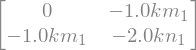

In [102]:
Gamma11

Gamma21

In [106]:
# 2 equations /4 incognites (From change the variables)
E1_gamma = (J12inv[0,0]*(J12.T*Tau12*J12+H0)+J12inv[0,1]*(J12.T*Tau22*J12+H1))
E2_gamma = (J12inv[1,0]*(J12.T*Tau12*J12+H0)+J12inv[1,1]*(J12.T*Tau22*J12+H1))

def Equations_with_CS(E1_gamma,E2_gamma,km1,kn1,km2,kn2,H111,H121,H221,H112,H122,H222,j11,j12,j22):
    EE3 = expand(simplify(-E1_gamma[0,0]/2-km1)*det(J12))
    EE4 = expand(simplify(-E2_gamma[1,1]/2-kn1)*det(J12))
    EE5 = expand(simplify(-E1_gamma[1,0]-kn1)*det(J12))
    EE6 = expand(simplify(-E2_gamma[1,0]-km1)*det(J12))
    #Gamma001
    b1 = H111*j22/2-H112*j12/2
    a11 = j12**2-j11*j22
    a12 = 0
    a13 = j11**2*j22-j11*j12**2
    a14 = j11*j12*j22-j12**3
    #Gamma112
    b2 = -0.5*H221*j12 + 0.5*H222*j11
    a21 = 0
    a22 = - 1.0*j11*j22+j12**2
    a23 = + j11*j12*j22 - j12**3
    a24 = + 1.0*j11*j22**2 - 1.0*j12**2*j22 
    #Gamma101
    b3 = H121*j22 - H122*j12
    a31 = 0
    a32 = j12**2 - j11*j22
    a33 = + 1.0*j11*j12*j22  - 1.0*j12**3
    a34 = - 1.0*j12**2*j22 +  1.0*j11*j22**2 
    #Gamma102
    b4 = -H121*j12 + H122*j11 
    a41 = -j11*j22+j12**2
    a42 = 0
    a43 = + 1.0*j11**2*j22 - 1.0*j11*j12**2
    a44 = - 1.0*j12**3 +1.0*j11*j12*j22
    expand(-b4+a41*km1+a42*kn1+a43*km2+a44*kn2)
    # Assemble matrices
    A = Matrix([[a11,a12,a13,a14],[a21,a22,a23,a24],[a31,a32,a33,a34],[a41,a42,a43,a44]])
    b = Matrix([[b1],[b2],[b3],[b4]])
    return A,b

A,b = Equations_with_CS(E1_gamma,E2_gamma,km1,kn1,km2,kn2,H111,H121,H221,H112,H122,H222,j11,j12,j22)

print(A.rank())

The rank of the linear system is 2 what give us two more equations. We obtain km1 and kn1 wrt. km2 and kn2.

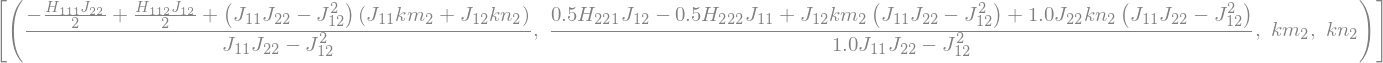

In [135]:
# Schwarzian equations
simplify(E1_gamma[1,1])
simplify(E2_gamma[0,0])

baux = Matrix([[(b[0,0])],[b[1,0]]])
Aaux = Matrix([(A[0,0:4]),(A[1,0:4])])

a = list(linsolve([Aaux,baux],[km1,kn1,km2,kn2]))
a

In [144]:
# kn2 and km2 depending on kn1 and km1
eqkn2 = a[0][1]-kn1
kn2aux = simplify(solve(eqkn2,kn2)[0])
eqkm2 = a[0][0].subs(kn2,kn2aux)-km1
km2aux = simplify(solve(eqkm2,km2)[0])
kn2aux = simplify(kn2aux.subs(km2,km2aux))

In [145]:
# 6 inc /2 eq -- Christophel symbols give you 2
EE1 = simplify(expand(g111/g121)-expand(G2J[0,0]/G2J[0,1]))
EE2 = simplify(expand(g221/g121)-expand(G2J[1,1]/G2J[0,1]))

EE1 = EE1.subs(kn2,kn2aux)
E1 = EE1.subs(km2,km2aux) 
EE2 = EE2.subs(kn2,kn2aux)
E2 = EE2.subs(km2,km2aux)

In [146]:
#Final equations
E1 = factor(E1)
E2 = factor(E2)
num1,den1 =fraction(E1)
num2,den2 =fraction(E2)

# Final equations
eq1 = Poly(num1,km1,kn1)
eq2 = Poly(num2,km1,kn1)

# Coeffs
eq1_3_0 = simplify(eq1.coeff_monomial(km1**3*kn1**0)) 
eq1_2_2 = simplify(eq1.coeff_monomial(km1**2*kn1**2)) # = 0
eq1_1_2 = simplify(eq1.coeff_monomial(km1**1*kn1**2)) # = 0
eq1_0_2 = simplify(eq1.coeff_monomial(km1**0*kn1**2)) # = 0
eq1_2_1 = simplify(eq1.coeff_monomial(km1**2*kn1**1)) 
eq1_2_0 = simplify(eq1.coeff_monomial(km1**2*kn1**0)) 
eq1_1_1 = simplify(eq1.coeff_monomial(km1**1*kn1**1))
eq1_1_0 = simplify(eq1.coeff_monomial(km1**1*kn1**0))
eq1_0_1 = simplify(eq1.coeff_monomial(km1**0*kn1**1))
eq1_0_0 = simplify(eq1.coeff_monomial(km1**0*kn1**0))

eq2_0_3 = simplify(eq2.coeff_monomial(km1**0*kn1**3))
eq2_2_2 = simplify(eq2.coeff_monomial(km1**2*kn1**2)) # = 0
eq2_1_2 = simplify(eq2.coeff_monomial(km1**1*kn1**2))
eq2_0_2 = simplify(eq2.coeff_monomial(km1**0*kn1**2))
eq2_2_1 = simplify(eq2.coeff_monomial(km1**2*kn1**1)) # = 0
eq2_2_0 = simplify(eq2.coeff_monomial(km1**2*kn1**0)) # = 0
eq2_1_1 = simplify(eq2.coeff_monomial(km1**1*kn1**1))
eq2_1_0 = simplify(eq2.coeff_monomial(km1**1*kn1**0))
eq2_0_1 = simplify(eq2.coeff_monomial(km1**0*kn1**1))
eq2_0_0 = simplify(eq2.coeff_monomial(km1**0*kn1**0))


In [ ]:
eq1_3_0